# Notebook for creating LDA topic models and coherence graphs
### Anton Elias Holt - exam in Computational linguistics at Aarhus University, spring 2021

# Import modules

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

import pyLDAvis


#Vigtigt at der står pyLDAvis.gensim_models og ikke pyLDAvis.gensim
import pyLDAvis.gensim_models

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

%matplotlib inline

nlp = spacy.load("en_core_web_sm")
"""The S string will be approximally 1.2m characters so I need to change the max_lenght from 1m to 2m"""
nlp.max_length = 2000000

## Testing things out individually

In [ ]:
text_file = open("data/big_tuples_string_DF2.txt", "r",encoding="UTF-8")
text = text_file.read()
text_file.close()

In [ ]:
doc = nlp(text)

In [ ]:
texts, article = [], []
for w in doc:
    # if it's not a stop word or punctuation mark, add it to our article!
    if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
        # we add the lematized version of the word
        article.append(w.lemma_)
    # if it's a new line, it means we're onto our next document
    if w.text == '\n':
        texts.append(article)
        article = []

In [ ]:
bigram = gensim.models.Phrases(texts)

In [ ]:
texts = [bigram[line] for line in texts]

In [ ]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [ ]:
"""I couldn't get the models to display directly in the notebook so I saved them to the computer instead"""
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(vis,'data/test_models/test_model2.html')

## Creating a function for automating the process

In [188]:
"""This function has changed numerous times, but it didn't use to include a random_state seed or the coherence score part"""
def save_model(big_string, party,i):
    text = big_string
    doc = nlp(text)
    
    texts, article = [], []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
            # I performed my own lemmatization, so this step differs from the Colab
            article.append(w.text)
        # if it's a new line, it means we're onto our next document
        if w.text == '\n':
            texts.append(article)
            article = []
    
    bigram = gensim.models.Phrases(texts)
    
    texts = [bigram[line] for line in texts]
    
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    ldamodel = LdaModel(corpus=corpus, num_topics = i, id2word=dictionary, random_state=np.random.RandomState(seed=123456))
    
    vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
    pyLDAvis.save_html(vis,'data/test_models/'+party+str(i)+'_test_model.html')
    print('file saved as:','data/test_models/'+party+str(i)+'_test_model.html')
    
    
    """Getting the coherence score"""
    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
    lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()
    print('Coherence score:', lda_coherence)
    return lda_coherence

In [189]:
"""Here i tested if I could recreate the scores with a randomstate seed. I couldn't
    I also tried logging the coherence score at the time of creation, but I got a 
    different one when I loaded the model again afterwards...."""
one_score = save_model(get_big_string('EL'),'EL_highest',57)
one_score in coherence_df['EL']

file saved as: data/test_models/EL_highest_test_model.html
Coherence score: 0.4624679955358889


False

In [1]:
"""This model saves 148 models for each parti, originally it saved 20
    This function was used for creating the coherence score graphs"""
def save_models_for_party(big_string, party):
    text = big_string
    doc = nlp(text)
    # we add some words to the stop word list
    texts, article = [], []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
            # we add the lematized version of the word
            article.append(w.text)
            #article.append(w)
        # if it's a new line, it means we're onto our next document
        if w.text == '\n':
            texts.append(article)
            article = []
    
    bigram = gensim.models.Phrases(texts)
    
    texts = [bigram[line] for line in texts]
    
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_scores = []
    
    for i in range(2,150,1):
        ldamodel = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=np.random.RandomState(seed=123456))
        ldamodel.save('data/gensim_model_files/'+party+'/'+party+str(i))
        
        """Getting the coherence score"""
        ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
        lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()
        coherence_scores.append(lda_coherence)
        
        if i%10 == 0:
            print(i)
        
    return coherence_scores
        
        #vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
        #pyLDAvis.save_html(vis,'data/models_24-05/'+party+'/'+party+str(i)+'_lemma_model.html')
        #print('file saved as:','data/models_24-05/'+party+'/'+party+str(i)+'_lemma_model.html')
        

In [7]:
"""Getting data for creating the coherence score graphs"""
dic = {}
for p in gode_partier:
    print(p)
    dic[p] = save_models_for_party(get_big_string(p),p)
    print('\n')
coherence_df = pd.DataFrame(dic)
coherence_df.to_pickle('coherence_df.pkl')

DF
10
20
30
40
50
60
70
80
90
100
110
120
130
140
EL
10
20
30
40
50
60
70
80
90
100
110
120
130
140
KF
10
20
30
40
50
60
70
80
90
100
110
120
130
140
RV
10
20
30
40
50
60
70
80
90
100
110
120
130
140
S
10
20
30
40
50
60
70
80
90
100
110
120
130
140
SF
10
20
30
40
50
60
70
80
90
100
110
120
130
140
V
10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [8]:
coherence_df

,DF,EL,KF,RV,S,SF,V
0,0.153594,0.125224,0.216043,0.277581,0.108301,0.133581,0.150763
1,0.227608,0.176186,0.242705,0.325698,0.127136,0.169737,0.137442
2,0.220430,0.201837,0.256673,0.301160,0.137846,0.158552,0.174501
3,0.225992,0.240464,0.245724,0.316887,0.193375,0.219182,0.206613
4,0.268666,0.221754,0.325401,0.324364,0.194026,0.227430,0.217581
...,...,...,...,...,...,...,...
143,0.442270,0.383773,0.403949,0.392479,0.420223,0.387866,0.367816
144,0.379314,0.370315,0.398691,0.377192,0.362110,0.409625,0.469147
145,0.387777,0.331779,0.460475,0.360411,0.307858,0.386195,0.323597
146,0.424916,0.387358,0.392860,0.404480,0.340087,0.460577,0.383964


# Here are the code I originally used to create several models for each party so that I could look through them and find the best number of topics. I have messed around too much in this notebook so it might not make sense

In [20]:
#
gode_partier = ['DF','EL','KF','RV','S','SF','V']

In [5]:
import pandas as pd
import pickle

In [24]:
sdf = pd.read_pickle('big_tuples_24-05_lemmatized.pkl')

def get_big_string(party):
    big_string = ""
    for tup in sdf['Tuples'][party]:
        big_string += tup[0] + '\n'
    return big_string

sdf

,Tuples
DF,[(bund kvik teste land plejehjem prioritere st...
EL,[(endelig våbenhvile israelpalæstina sikre bær...
KF,"[(ærlig god orkere bøvl indkøbspolet , KF), (v..."
RV,[(diskriminere egne statsborger bære selvfølge...
S,[(fantastisk inspirerende møde dansker forudgå...
SF,[(stoppe stigmatisering psykisk sygdom ufattel...
V,[(underligt forløbe forhandling regi klimalov ...


In [8]:
"""creating the biggest_string"""
biggest_string = ""
for p in gode_partier:
    biggest_string += get_big_string(p) + ' '
print(len(biggest_string))

4122939


In [ ]:
"""THIS CAN ABSOLUTELY NOT RUN ON YOUR OWN COMPUTER. USE COLAB FOR THIS!!!!"""
save_models_for_party(biggest_string,'All')

In [ ]:
"""Create models for each party"""
"""When I first ran this, the range for the save_models_for_party had range(2,20,1)"""
for p in gode_partier:
    print(p)
    save_models_for_party(get_big_string(p),p)
    print('\n')

# Below are some of the code I used for estimating coherence scores:

In [143]:
"""change the range of i to get different amounts of coherence scores"""
def get_coherence_score_for_party(big_string, party):
    text = big_string
    doc = nlp(text)
    # we add some words to the stop word list
    texts, article = [], []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
            # we add the lematized version of the word
            article.append(w.text)
            #article.append(w)
        # if it's a new line, it means we're onto our next document
        if w.text == '\n':
            texts.append(article)
            article = []
    
    bigram = gensim.models.Phrases(texts)
    
    texts = [bigram[line] for line in texts]
    
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    coherence_scores = []
    for i in range(2,70,1):
        ldamodel = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=np.random.RandomState(seed=123456))
        
        """Getting the coherence score"""
        ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
        lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()
        print(i, lda_coherence)
        coherence_scores.append(lda_coherence)
    return coherence_scores

In [155]:
scores = get_coherence_score_for_party(get_big_string('EL'),'EL')

2 0.12522448994842672
3 0.17618623264257463
4 0.20183696435785672
5 0.24046449040688817
6 0.22175426910947627
7 0.22675538597316877
8 0.26159708257021086
9 0.2934046333972199
10 0.3144355999459793
11 0.2906756777247811
12 0.3186505864029517
13 0.3581156552813608
14 0.3743202034987135
15 0.33605759700898263
16 0.3514347100448041
17 0.34895113554320356
18 0.3726333677309629
19 0.3279644220962775
20 0.34103141994705716
21 0.36986170461699525
22 0.39899514471008607
23 0.3813108845252503
24 0.3810509261167798
25 0.36858363222762647
26 0.4175809353622009
27 0.3377419023931339
28 0.4083283313731149
29 0.4001272812043302
30 0.4374667780812313
31 0.4001639724157319
32 0.41099005448614073
33 0.3991074464349997
34 0.4133134808960667
35 0.39426052496205
36 0.3787071213514346
37 0.4251829411741725
38 0.4052492000471382
39 0.4352898838448501
40 0.4399964974098509
41 0.38059646920922247
42 0.4164685065232224
43 0.47059125013597036
44 0.4011035634139182
45 0.4473813208132456
46 0.466547833738929
47 0.

In [37]:
def create_plot(scores):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure()
    ax = plt.axes()
    plt.xlabel('number of topics')
    plt.ylabel('coherence score')
    x = [i for i in range(2,len(scores)+2,1)]
    ax.plot(x, scores)

0.5824089274498995


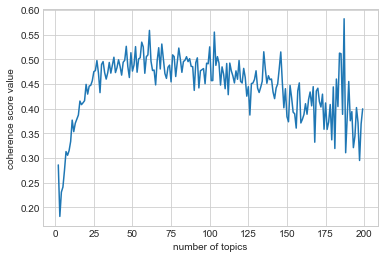

In [49]:
print(max(scores))
create_plot(scores)

0.4986707964958305
0.4986707964958305


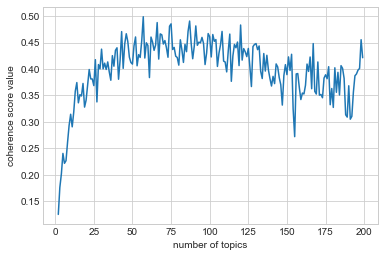

In [133]:
print(max(scores))
print(scores[55])
create_plot(scores)

In [18]:
coherence_df = pd.read_pickle('coherence_df.pkl')

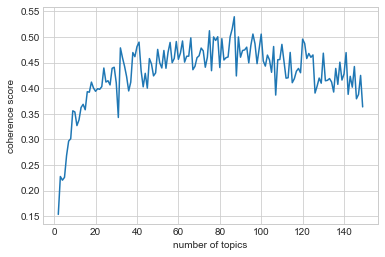

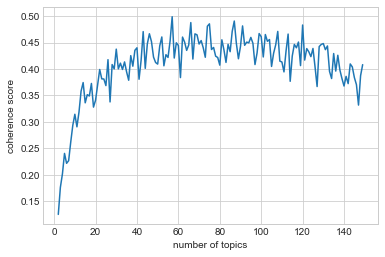

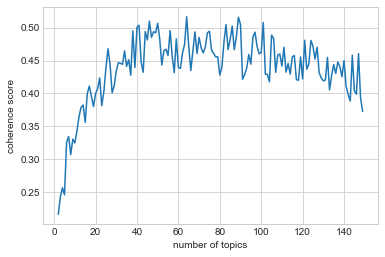

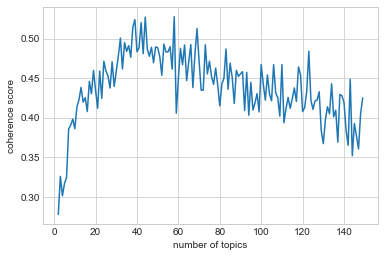

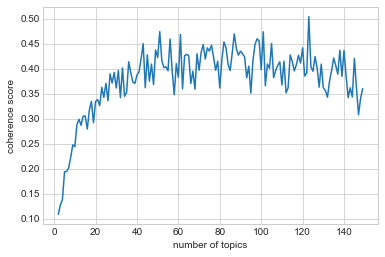

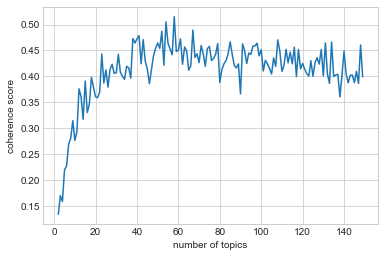

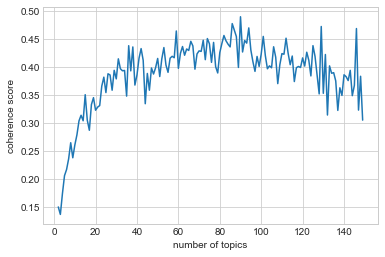

In [38]:
"""These are the plots included in Appendix 7"""
for p in gode_partier:
    create_plot(coherence_df[p])

In [45]:
"""Getting the max coherence scores"""
for p in gode_partier:
    for i, cs in enumerate(coherence_df[p]):
        if cs == max(coherence_df2[p]):
            print(p, i+2, cs, '\n')

DF 87 0.5394859074245595 

EL 57 0.4986707964958305 

KF 64 0.5165838101944161 

RV 58 0.5275516889603735 

S 123 0.5035632134574752 

SF 58 0.5149718683582115 

V 129 0.47281671800565095 

